# Когортный анализ развлекательного мобильного приложения

### Постановка задачи

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки

**Цель исследования** — разобраться в причиных убытков и помочь компании выйти в плюс.

**Задача исследования**:

* изучить, откуда приходят пользователи и какими устройствами они пользуются,
* понять, сколько стоит привлечение пользователей из различных рекламных каналов;
* выяснить, сколько денег приносит каждый клиент,
* определить, когда расходы на привлечение клиента окупаются,
* определить, какие факторы мешают привлечению клиентов.
* провести исследовательский анализ данных: изучить портерт аудитории в разрезе страны, устройства и источника привлечения;
* изучить маркетинговые затраты компании;
* проанализировать бизнес-показатели компании: ROI, LTV, CAC;
* написать выводы и рекомендации

### Описание данных

В вашем распоряжении три датасета:

`visits_info_short.csv` — хранит лог сервера с информацией о посещениях сайта

* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.

`orders_info_short.csv` — хранит информацию о заказах

* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.

`costs_info_short.csv` — хранит иформацию о расходах на рекламу.

* `dt` — дата проведения рекламной кампании,
* `Channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

### План исследования

* Импортировать библиотеки
* Загрузить данные
* Провести предобработку данных
* Написать функции для расчета показателей когортного анализа: LTV, CAC, ROI
* Составить профили пользователей
* Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
* Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
* Изучить рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей.
* Посчитать общую сумму расходов на маркетинг.
* Выяснить, как траты распределены по рекламным источникам.
* Построить график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику.  
* Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.
* Оценить окупаемость рекламы, используя графики LTV, ROI и CAC
* Написать выводы


### Импортирование библиотек

In [1]:
# Импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import warnings

# Игнорировать все предупреждения
warnings.simplefilter("ignore")

# Зададим стиль для всех графиков
sns.set_style('darkgrid')

### Загрузка данных

In [2]:
# Чтение файлов
visits = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_cohort-analysis_app/visits_info.csv')
orders = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_cohort-analysis_app/orders_info.csv')
costs = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_cohort-analysis_app/costs_info.csv')

    
# Создадим переменные datasets и df_names со списком датафреймов и их названиями
# это понадобится для предобработки данных
datasets = [visits, orders, costs]
df_names = ['visits', 'orders', 'costs' ]

Напишем функцию `data_info`, которая выведет основную информацию о каждом датафрейме. В качестве параметров функция будет принимать список с датафреймами и список с их названиями.

In [3]:
# Объявление функции
def data_info(dfs, df_names):
    
    # Цикл, который применят методы .info() и head()
    for df, name in zip(dfs, df_names):
        display ('Датафрейм {}'.format(name))
        df.info()
        display (df.head())

# Вызов функции
data_info(datasets, df_names)

'Датафрейм visits'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


'Датафрейм orders'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


'Датафрейм costs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Предобработка данных

В датафреймах необходимо сделать следующие преобразования:

* В заголовах столбцов все прописные буквы нужно заменить на строчные. Также, нужно переписать их в "змеином" стиле. Например, столбец `User Id` нужно переименовать в `user_id`. Это упростит работу с данными;
* В столбцах с датой и временем нужно изменить тип `object` на тип `datetime`, это позволит делать вычисления с датами.

Для первого преобразования напишем цикл.

In [40]:
# Замена названий колонок
for df in datasets:
    # заменим пробелы на "_" для "змеиного" стиля
    df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True) 
    df.columns = df.columns.str.lower() # сделаем все буквы строчными

Теперь выполним второе преобразование — заменим тип данных там, где это необходимо.

In [5]:
# Замена типов данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим внесенные изменения, снова вызовем функцию `data_info`

In [6]:
# Вызов функции
data_info(datasets, df_names)

'Датафрейм visits'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


'Датафрейм orders'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


'Датафрейм costs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Все изменения успешно внесены: названия колонок изменены, тип данных преобразован.

Теперь проверим датафреймы на наличие пропусков и дубликатов, для этого напишем функцию `data_check`. В качестве параметров передадим ей список датафреймов и список их названий.

In [7]:
def data_check (dfs, df_names):
    
    # Цикл, который считает количество дубликатов в каждом датафрейме
    for df, name in zip(dfs, df_names):
        display('В датафрейме {} количество дубликатов равно {}'.format(name, df.duplicated().sum())) 
    
    # Цикл, который считает количество пропусков в каждом датафрейме
    for df, name in zip(dfs, df_names):
        display ('Пропуски в датафрейме {}'.format(name))
        display (df.isna().sum())
        
# Вызов функции
data_check(datasets, df_names)

'В датафрейме visits количество дубликатов равно 0'

'В датафрейме orders количество дубликатов равно 0'

'В датафрейме costs количество дубликатов равно 0'

'Пропуски в датафрейме visits'

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

'Пропуски в датафрейме orders'

user_id     0
event_dt    0
revenue     0
dtype: int64

'Пропуски в датафрейме costs'

dt         0
channel    0
costs      0
dtype: int64

Пропуски и дубликаты в датафреймах отсутствуют.

### Функции для когортного анализа

Создадим следующие функции для когортного анализа

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция `get_profiles()`

In [8]:
def get_profiles(sessions, orders, ad_costs, events = None, event_names=[]):
 
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )
 
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles = profiles.query('channel != "organic"')
 
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
    # добавляем флаги для всех событий из event_names (совсем не понимаю, зачем они нужны)
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
 
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
 
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
 
    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
 
    return profiles  # возвращаем профили с CAC


#### Функция `get_retention()`

In [9]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # внутри функции get_retention() вызываем функцию group_by_dimensions и получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # внутри функции get_retention() вызываем функцию group_by_dimensions и получаем таблицу динамики удержания
    # здесь мы по умолчанию добавляем группировку по дате привлечения
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция `get_conversion()`

In [10]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort'] 

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)

        result = result[['cohort_size'] + list(range(horizon_days))]

        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    # на самом деле его можно не убирать, просто на этапе построения графика можно "дропнуть"
    if 'cohort' in dimensions: 
        dimensions = [] 

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция `get_ltv()`

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
        
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция `filter_data()`

In [12]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция `plot_retention()`

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция `plot_conversion()`

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция `plot_ltv_roi()`

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Проведем исследовательский анализ данных. Для начала составим профили пользователей — вызовем функцию `get_profiles()`

In [16]:
# Вызов функции get_profiles()
profiles = get_profiles(visits, orders, costs, costs)

Определим минимальную и максимальную даты привлечения пользователей.

In [17]:
display (profiles['first_ts'].max())
display (profiles['first_ts'].min())

Timestamp('2019-10-27 23:59:04')

Timestamp('2019-05-01 00:00:41')

Минимальная дата привлечения пользователя — 1 мая 2019 года, максимальная — 27 октября 2019 года.

Теперь пострим таблицы с указанием количества пользователей, количества платящих пользователей и доли платящих пользователей отдельно в разбивке по странам,  устройствам и рекламным источникам. Чтобы не вызывать похожий код несколько раз, напишем функцию `payers_stat()`, которая будет формировать таблицу в разбивке по желаемым параметрам. В качестве входных параметров функции укажем профили клиентов и параметр `dimension`.

In [18]:
def payers_stat(profiles, dimension):
    
    # Отдельно создадим таблицу с числом уникальных платящих пользователей и группировкой по параметру dimesion
    paying_users = (

    profiles.loc[profiles['payer'] == True]
            .groupby(dimension)
            .agg({'user_id':'nunique'})
            .reset_index()
            .rename(columns={'user_id':'paying_users'})
    )

    # Создадим таблицу с числом всех уникальных пользователей и группировкой по параметру dimesion
    users_by_dimension = (
    
    profiles.groupby(dimension)
            .agg({'user_id':'nunique'})
            .reset_index()
             # Присоединим таблицу paying_users
            .merge(paying_users, on=dimension, how='left')
            .rename(columns={'user_id': 'users'})

    )

    # Добавим столбец с долей платящих пользователей
    users_by_dimension['%_of_payers'] = users_by_dimension['paying_users']/users_by_dimension['users']
    users_by_dimension = users_by_dimension.sort_values(by='%_of_payers', ascending=False)
    
    # Поменяем вшений вид данных
    users_by_dimension['%_of_payers'] = users_by_dimension['%_of_payers'].apply(lambda x: '{:.2%}'.format(x))
    users_by_dimension['users'] = users_by_dimension['users'].apply(lambda x: '{:,.0f}'.format(x))
    users_by_dimension['paying_users'] = users_by_dimension['paying_users'].apply(lambda x: '{:,.0f}'.format(x))

    return users_by_dimension


Функция написана. Проверим, как она работает — создадим таблицу пользвателей в разбивке по странам.

In [19]:
payers_stat(profiles, 'region')

,region,users,paying_users,%_of_payers
3,United States,"61,829","6,108",9.88%
1,Germany,"9,528",490,5.14%
2,UK,"11,154",569,5.10%
0,France,"11,058",554,5.01%


У приложения большего всего пользователей из США, более 60 тыс. Доля платящих пользователей в США также самая высокая, почти 10%.

Посмотрим на данные в разбивке по устройствам.

In [20]:
payers_stat(profiles, 'device')

,device,users,paying_users,%_of_payers
1,Mac,"18,693","1,673",8.95%
3,iPhone,"33,882","2,972",8.77%
0,Android,"21,841","1,782",8.16%
2,PC,"19,153","1,294",6.76%


Больше всего пользователей (33 тыс.) заходят в приложение с iPhone. Самая высокая доля платящих пользователей у Mac — 8,95%.

Теперь рассмотрим пользователей по каналам привлечения

In [21]:
payers_stat(profiles, 'channel')

,channel,users,paying_users,%_of_payers
1,FaceBoom,"29,144","3,557",12.20%
0,AdNonSense,"3,880",440,11.34%
9,lambdaMediaAds,"2,149",225,10.47%
6,TipTop,"19,561","1,878",9.60%
5,RocketSuperAds,"4,448",352,7.91%
7,WahooNetBanner,"8,553",453,5.30%
8,YRabbit,"4,312",165,3.83%
3,MediaTornado,"4,364",156,3.57%
2,LeapBob,"8,553",262,3.06%
4,OppleCreativeMedia,"8,605",233,2.71%


Среди рекламных источников самая высокая доля платящих пользователей у FaceBoom, lambdaMediaAds и AdNonSense, более 10%.

### Оценка окупаемости рекламы

Проведем анализ маркетинговых затрат. Для начала посчитаем общую сумму расходов на маркетинг.

In [22]:
costs['costs'].sum()

105497.30000000002

Общая сумма расходов на маркетинг за анализируемый период составила более 100 тыс. долларов.

Теперь выясним, как расходы распределены по рекламным источникам.

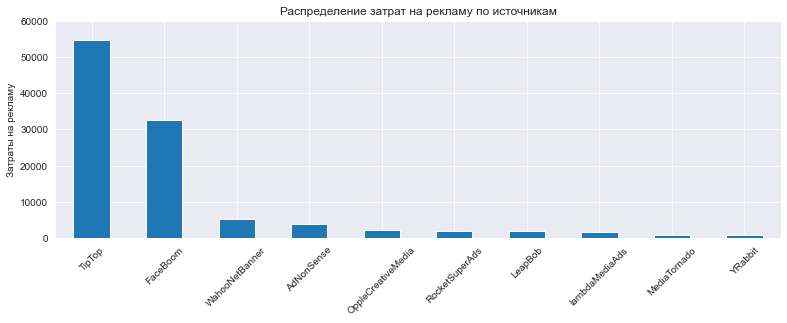

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [23]:
# Сгруппируем данные о расходах по каналам привлечения               
channel_costs = ( 
    
    costs.groupby('channel')
         .agg({'costs':'sum'})
         .sort_values(by='costs', ascending=False)
         
)

# Построим столбчатую диаграмму 
channel_plot = channel_costs.plot(kind='bar',
                                  figsize=(13,4),
                                  title='Распределение затрат на рекламу по источникам',
                                  legend=False,
                                  grid=True)
      
plt.xticks(rotation=45);
plt.xlabel("")
plt.ylabel("Затраты на рекламу")
plt.ylim(0, 60000);
plt.show()

display(channel_costs)

Больше всего средств было потрачено на источники TipTop и Faceboom: более 5 тыс. и 3 тыс. долларов соответственно. На остальные источники затраты не превысыли и тысячи долларов.

Построим визуализацию динамики изменения расходов во времени по каждому источнику.

In [24]:
# Сделаем столбцы с номерами недель и месяцев. Для этого сначала преобразуем столбец dt в тип datetime
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.week
costs['month'] = costs['dt'].dt.month

# Снова преобразуем столбец dt — оставим только дату, без времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Построим графики с динамикой затрат.

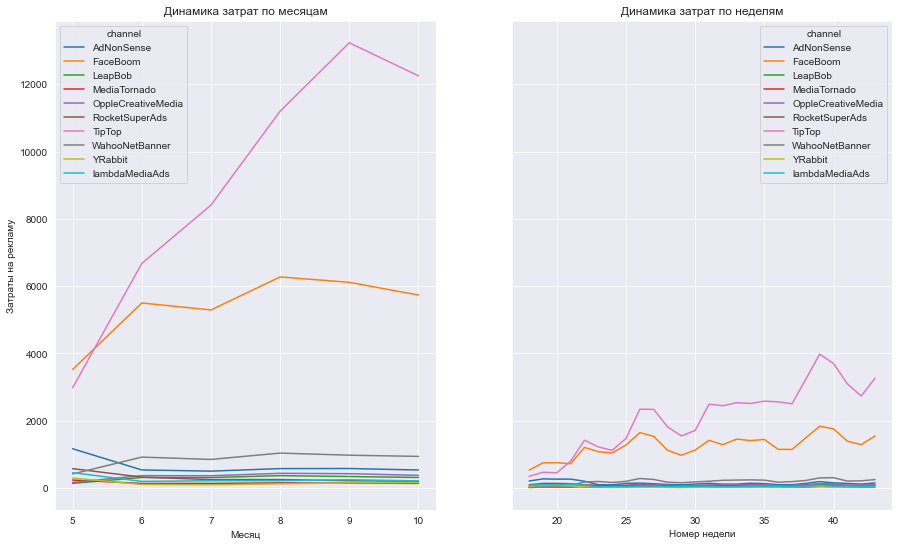

In [25]:
# Зададим размер фигуры
plt.figure(figsize=(15, 9))

# Сохраним первый график в первой ячейке
ax1 = plt.subplot(1, 2, 1)

(
    # Построим график динамики затрат по месяцам 
    costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
         .plot(title='Динамика затрат по месяцам', grid=True, ax=ax1)
)

plt.xlabel("Месяц")
plt.ylabel("Затраты на рекламу")

(
    # Построим график динамики затрат по неделям 
    costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
         .plot(title='Динамика затрат по неделям', grid=True, ax=plt.subplot(1, 2, 2, sharey=ax1))
)

plt.xlabel("Номер недели")
plt.ylabel("Затраты на рекламу");

По неделям и по месяцам динамика расходов выделяется у площадок TipTop и Faceboom. 

На TipTop в июне было потрачено около 3,5 тыс. долларов, к сентябрю ежемесячные затраты по этому источнику уже выросли до 12,5 тыс долларов. Затраты на Faceboom также росли, но медленее с 3,8 тыс. долларов в июне до 6,1 тыс. долларов в августе, затем расходы немного снизились.

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.


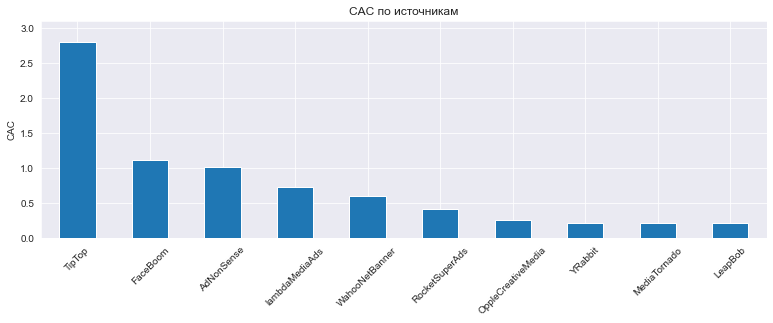

,channel,acquisition_cost
6,TipTop,2.80
1,FaceBoom,1.11
0,AdNonSense,1.01
9,lambdaMediaAds,0.72
7,WahooNetBanner,0.60
5,RocketSuperAds,0.41
4,OppleCreativeMedia,0.25
8,YRabbit,0.22
3,MediaTornado,0.22
2,LeapBob,0.21


In [26]:
cac = (
    
    # Сделаем сводную таблицу: в строках укажем канал, в столбцах — CAC
    profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
            .reset_index()
             # Исключим органику
            .query('channel != "organic"')
            .sort_values('acquisition_cost', ascending=False)

)

cac['acquisition_cost'] = cac['acquisition_cost'].round(2)

# Построим столбчатую диаграмму
ax = cac.plot(x='channel',
                  y='acquisition_cost',
                  kind='bar',
                  legend=False,
                  title='CAC по источникам',
                  grid=True,
                  figsize=(13,4))

plt.xticks(rotation=45);
plt.ylabel("CAC");
plt.xlabel("")
plt.ylim(0,3.1)
plt.show()

display(cac)

У площадок TipTop и Faceboom самая высокая стоимость привлечения пользователя: 2,8 и 1,1 долларов соответственно. Компания тратит достаточно много рекламного бюджета на источники с самой дорогой стоимостью привлечения.

Проведем оценку окупаемости затрат на рекламу.

In [27]:
# Зададим дату анализа — 1 ноября 2019 года
observation_date = datetime(2019, 11, 1).date()

# Зададим горизонт анализа в 14 дней, на этот день расходы на рекламу должны окупиться согласно бизнес-плану
horizon_days = 14

Посмотрим на общую окупаемость рекламы c помощью графиков, вызовем функцию `plot_ltv_roi()`

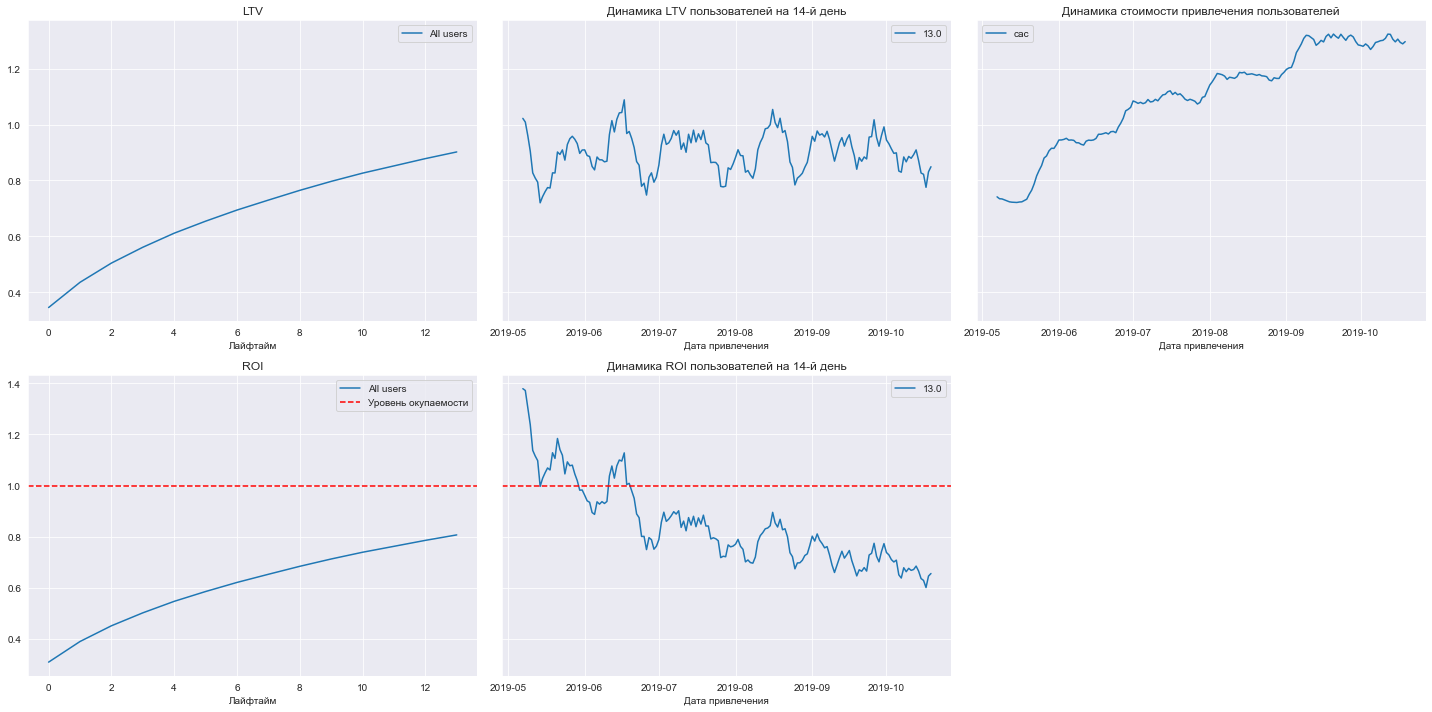

In [28]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles,
                                                      orders,
                                                      observation_date,
                                                      horizon_days,
                                                      dimensions=[])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

Можно сделать слующие выводы:

* Затраты на рекламу не окупаются — ROI на конец двухнедельного периода чуть выше 80%.
* Начиная с июня стоимость привлечения пользователя начала существенно увеличиваться, ее рост составил от 0,7 долларов в мае до почти 1,3 долларов в октябре.
* Расходы на рекламу перестали окупаться начиная с середины июня. Как раз после резкого роста CAC.
* LTV все это время оставался относительно стабильным и колебался в пределах от 0,8 до 1 доллара.

Теперь изучим общую конверсию: вызовем функции `get_conversion()` и `plot_conversion()`

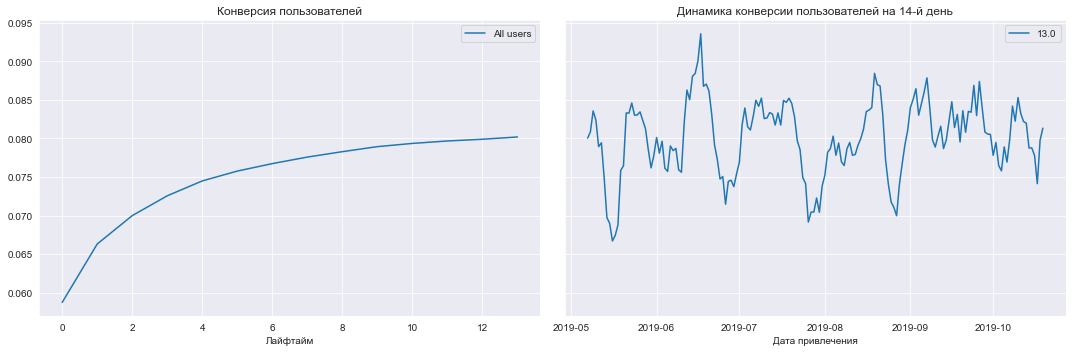

In [29]:
conversion_raw, conversion, conversion_history = get_conversion(profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=[])

plot_conversion(conversion, conversion_history, horizon_days, window=7)

На 14-й день общая конверсия составляет примерно 8%.

Посмотрим на удержание — вызовем функции `get_retention()` и `plot_retention()`.

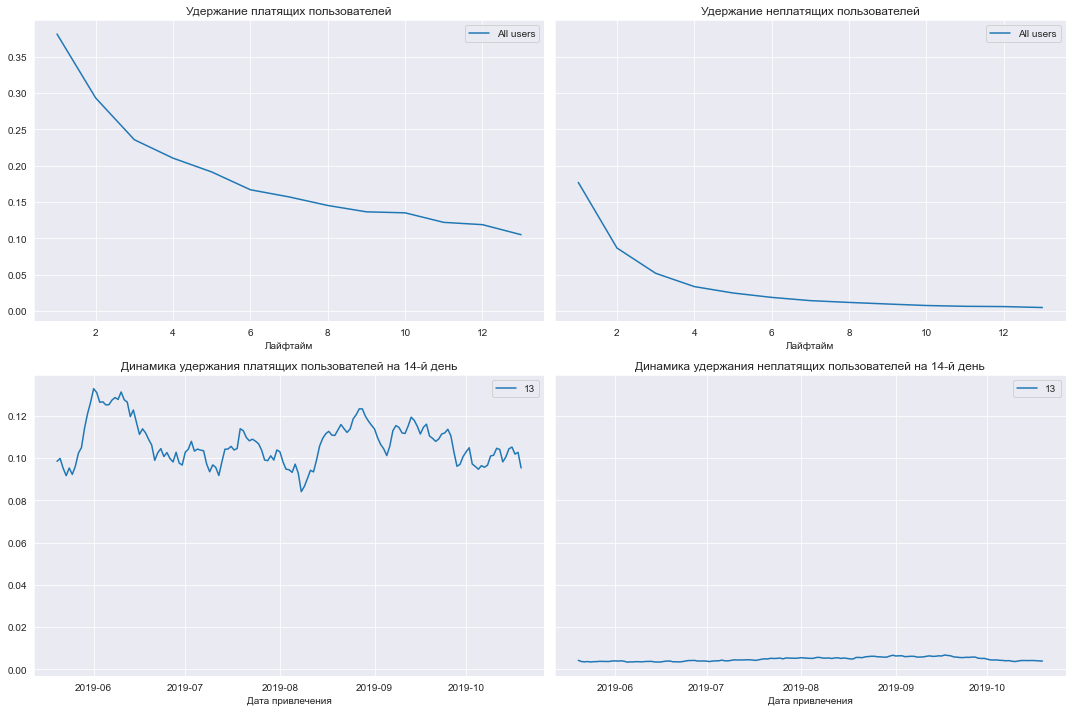

In [30]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=[])

plot_retention(retention, retention_history, horizon_days, window=20)

* Около 10% платящих пользователей остаются в приложении на 14-день после привлечения. У неплатящих пользователей этот показатель падает почти до нуля. 
* Динамика удержания в целом стабильная, показатель варьируется от 8% до 15%.

Попытаемся выснить, в чем причина низкой окупаемости. Расмотрим показатели в разбивке по устройствам.

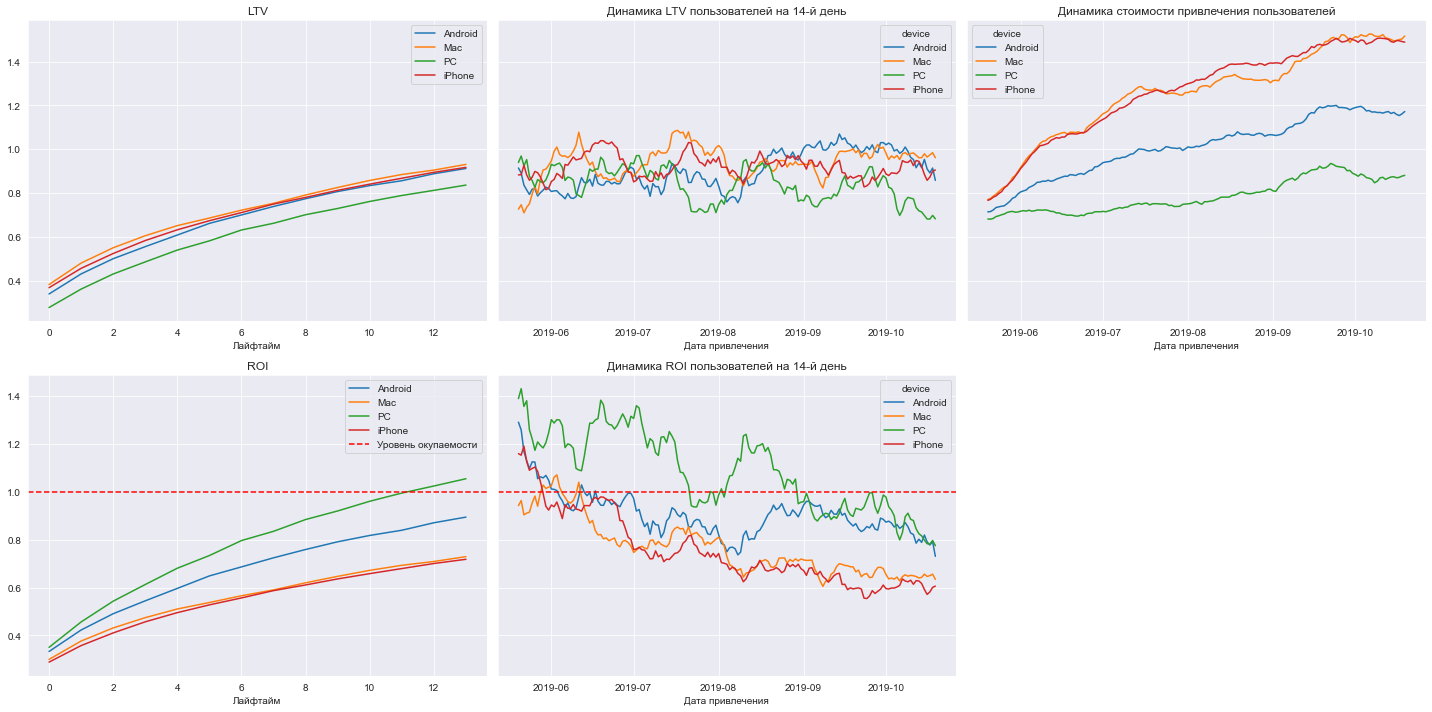

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles,
                                                      orders,
                                                      observation_date,
                                                      horizon_days,
                                                      dimensions=['device'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=20)

* Среди всех пользователей приложения окупаются только пользователи PC. Самая низкая окупаемость у пользователей iPhone и Мac, около 70%.
* ROI стабильно снижается для всех устройств, но для iPhone и Mac падения ROI более выражено. 
* LTV на всех устройствах относительно стабилен, с незначительным колебанием.
* Уровень CAC растет у пользователей всех устройств, но у iPhone и Mac средние затраты на прилечения пользователей самые высокие.
* Про графикам видно, что на всех устройствах, кроме PC, уровень CAC превышает LTV.

Теперь рассмотрим конверсии.

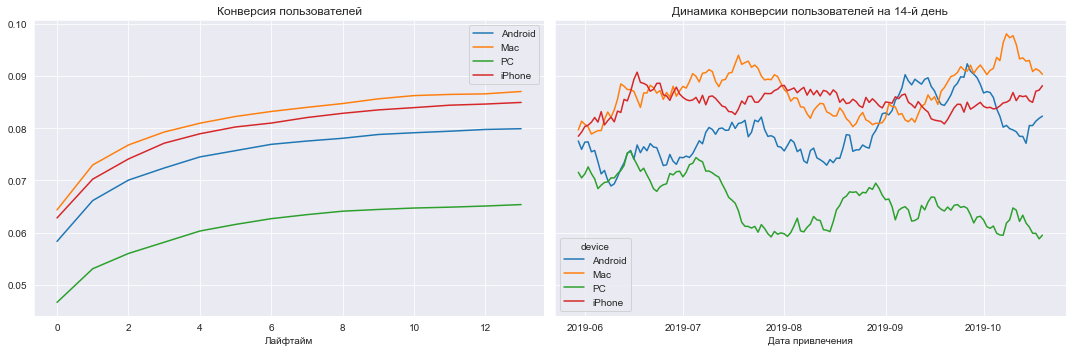

In [32]:
conversion_raw, conversion, conversion_history = get_conversion(profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['device'])

plot_conversion(conversion, conversion_history, horizon_days, window=30)

У пользователей PC самая низкая конверсия 14-го дня, чуть меньше 5%. Несмотря на низкую по сравнению с другими устройствами конверсионность, привлечение пользователей PC окупается благодаря относительно низкому CAC. То есть, той доли пользователей, совершивших целевое дейстие достаточно для того, чтобы окупить относильно невысокие затраты на привлечение. 

У пользователей Mac и iPhone обратная ситуация — у них самая высокая конверсия (более 6%), но пользователи этих устройств генерируют почти такой же LTV, как и пользователи остальных устройств. При этом затраты на привлечение пользователей очень высокие, из-за этого они не окупаются.

Изучим удержание пользователей.

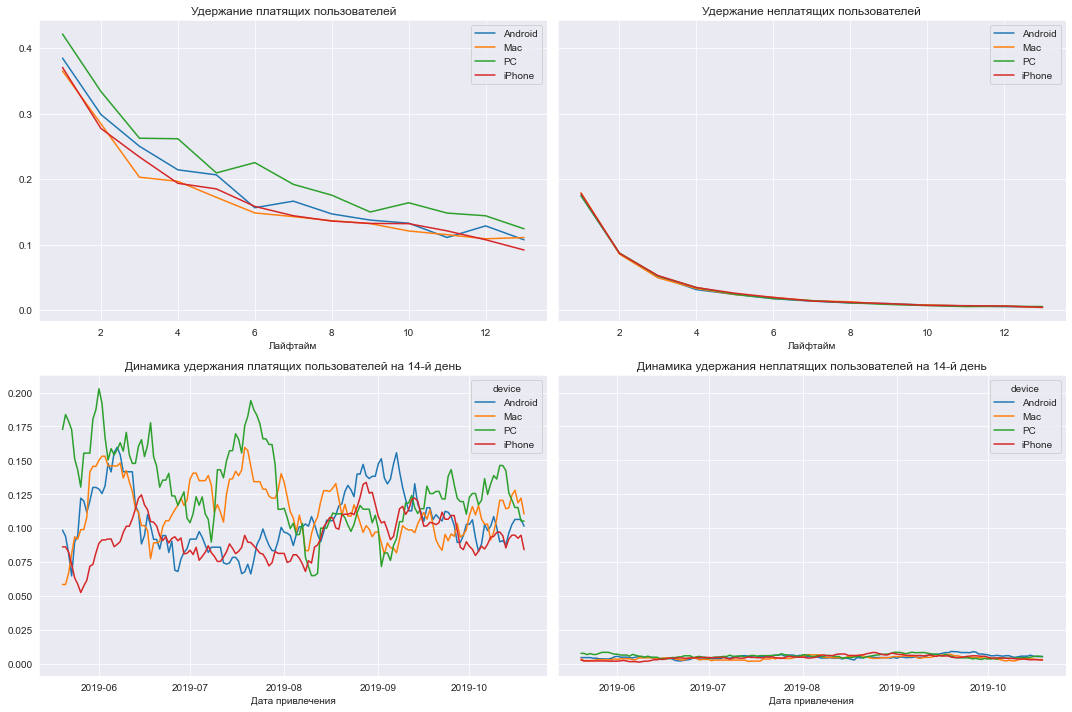

In [33]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['device'])

plot_retention(retention, retention_history, horizon_days, window=20)

В целом удеражение на всех устройстах примерно одинаковое, среди платящих пользователей незначильное лидерство есть у пользователей PC.

Теперь рассмотрим метрики в разбивке по странам, начнем с LTV, ROI и CAC.

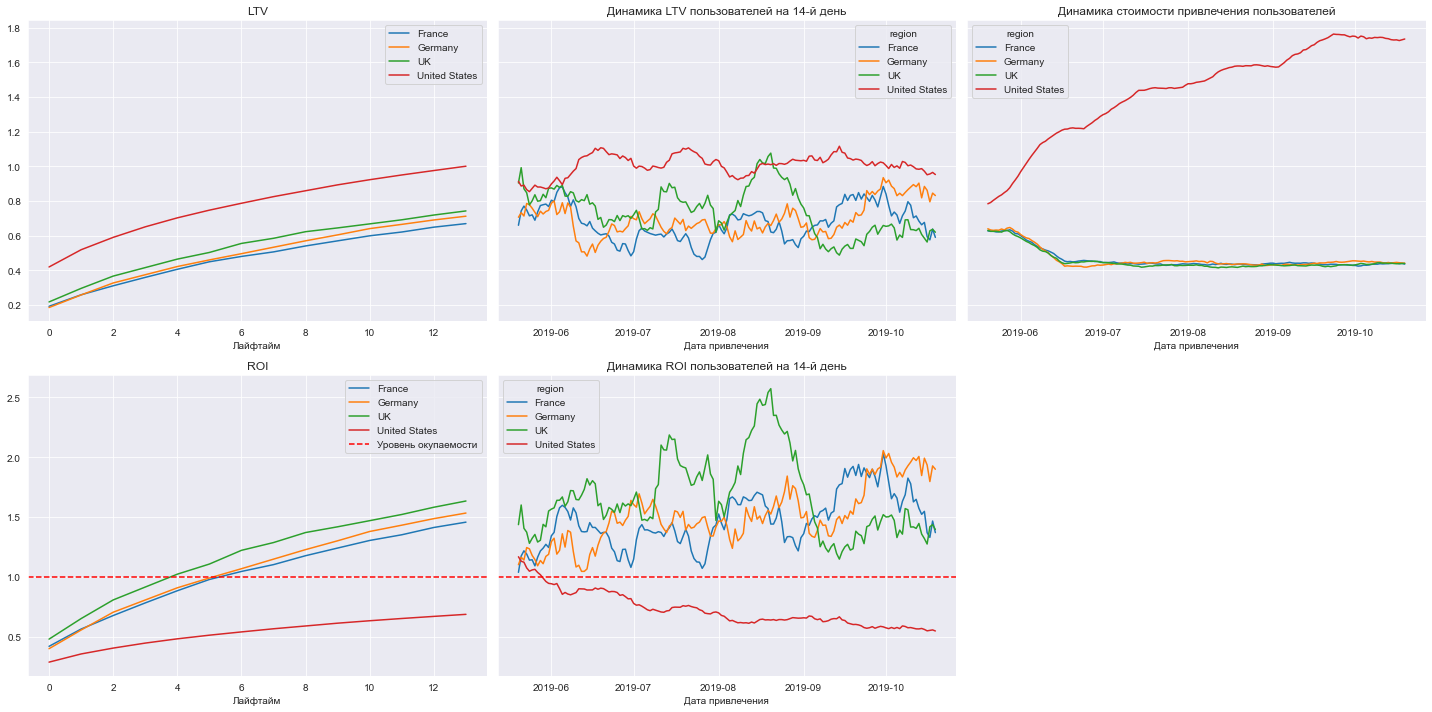

In [34]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles,
                                                      orders,
                                                      observation_date,
                                                      horizon_days,
                                                      dimensions=['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=20)

* Привлечение пользователей из США существенно не окупается, ROI на 14-й день составляет около 80%. Для сравнения, ROI других стран варьюируется от 180% до 210%. Привлечение американских пользователей перестало окупаться в начале июня.
* На графике видно, что стоимость привлечения американских пользователей существенно выше других стран. За период с мая по октябрь CAC вырос почти в три раза: с 0,4 долларов до 1,2 долларов.
* Привлечение американсих пользователей не окупается даже с учетом самого высокого LTV из-за слишком высокой стоимости привлечения.

Рассмотрим показатели конверсии.

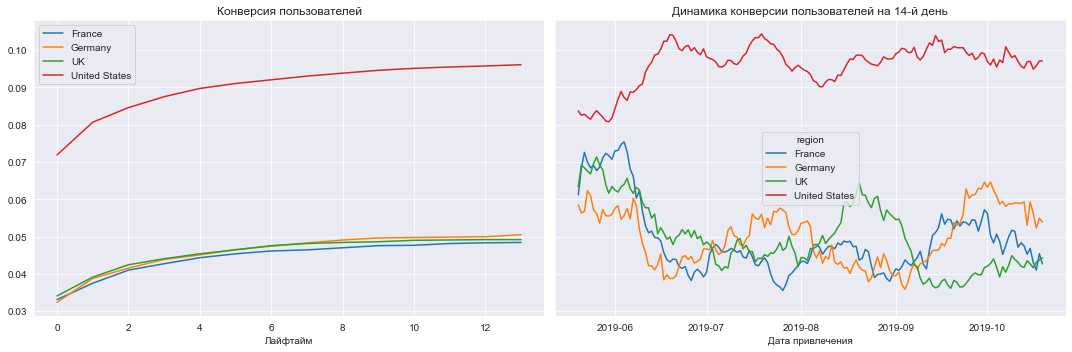

In [35]:
conversion_raw, conversion, conversion_history = get_conversion(profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['region'])

plot_conversion(conversion, conversion_history, horizon_days, window=20)

У пользователей из США конверсия на 2-3% выше, чем у других пользователей из других стран. Тем не менее, даже с учетом хорошей конверсионности и высокого LTV, затраты на привлечение не окупаются из-за слишком высокого CAC.

Рассмотрим показатели удержания.

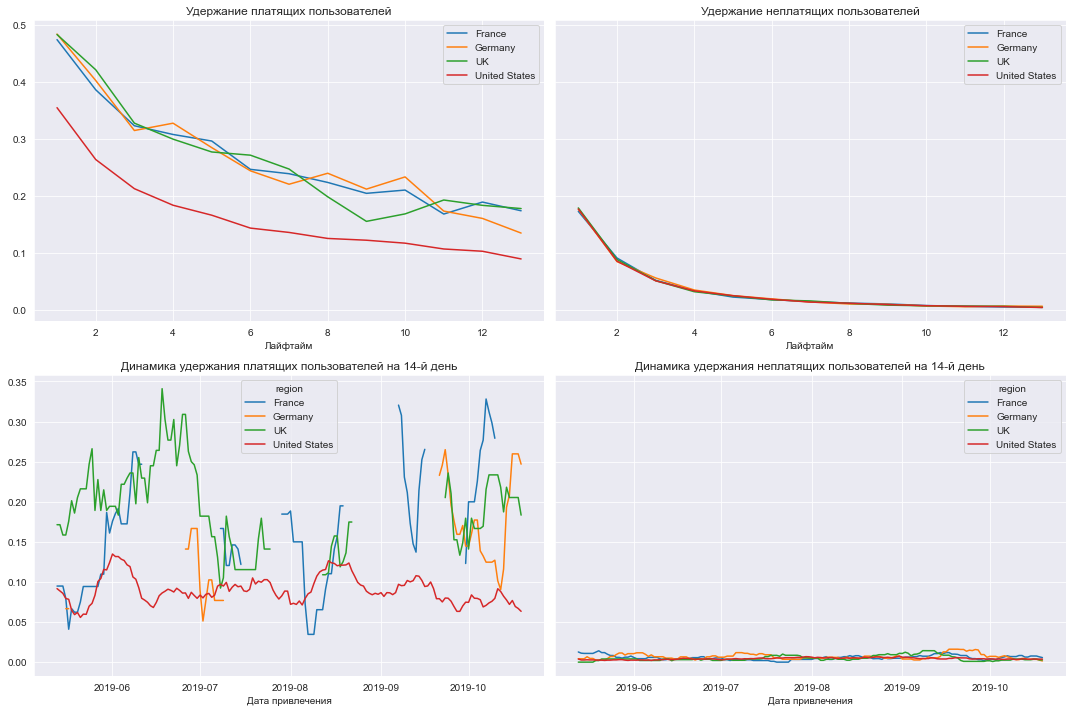

In [36]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['region'])

plot_retention(retention, retention_history, horizon_days, window=13)

Удержание пользователей из Франции, Германии и Великобритании на 14-й день находится примерно на одном уровне: от 18% до 20%. У пользователей из США Retention Rate заметно ниже, он составляет всего 10%. 

Теперь расмотрим метрики в разбивке по каналам привлечения.

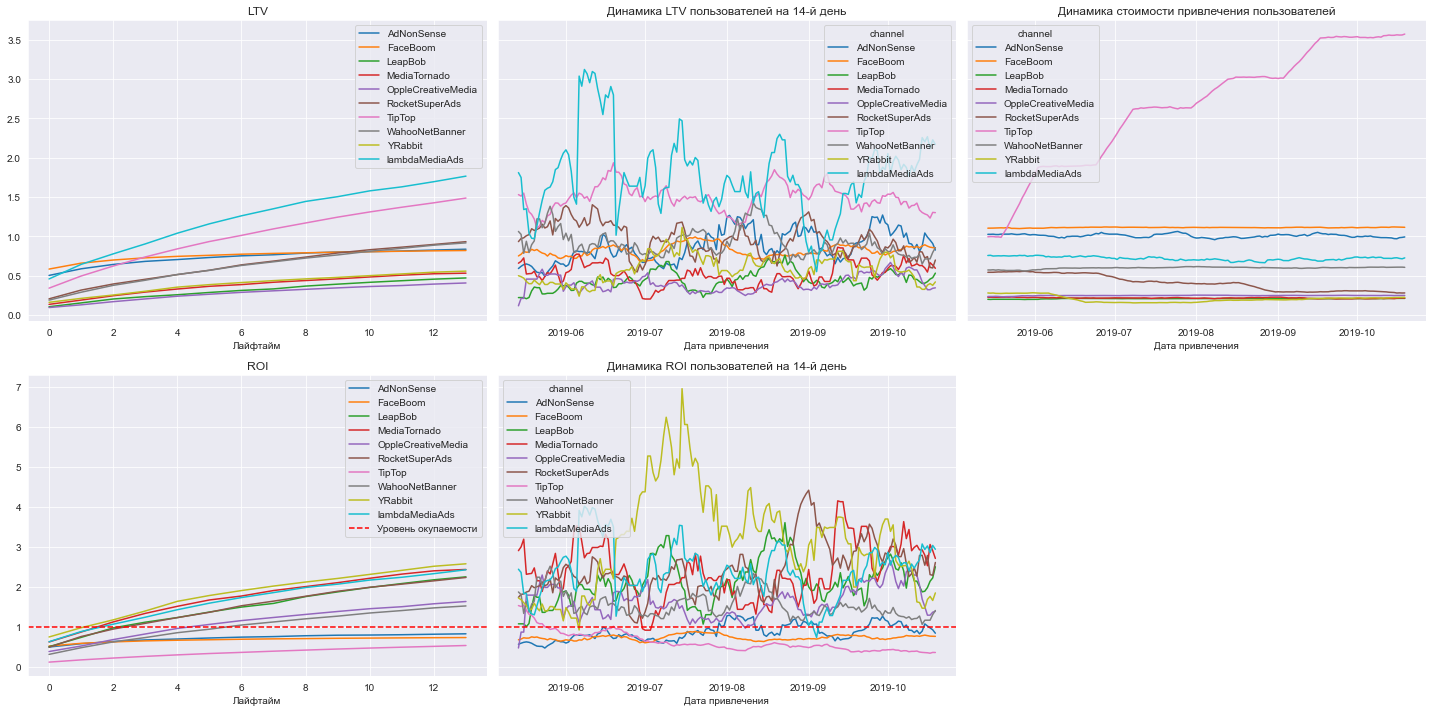

In [37]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles,
                                                      orders,
                                                      observation_date,
                                                      horizon_days,
                                                      dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

* Пользователи, привлеченные из AdNonSence, Faceboom и TipTop не окупаются из-за высокой стоимости привлечения.
* Самый дорогой CAC у канала TipTop — в октябре он достиг 3,5 долларов. У этой же площадки худшая окупаемость.
* Лучшие результаты с точки зрения окупаемости показывают каналы YRabbit, Media Tornado и lambdaMediaAds.

Рассмотрим конверсию.

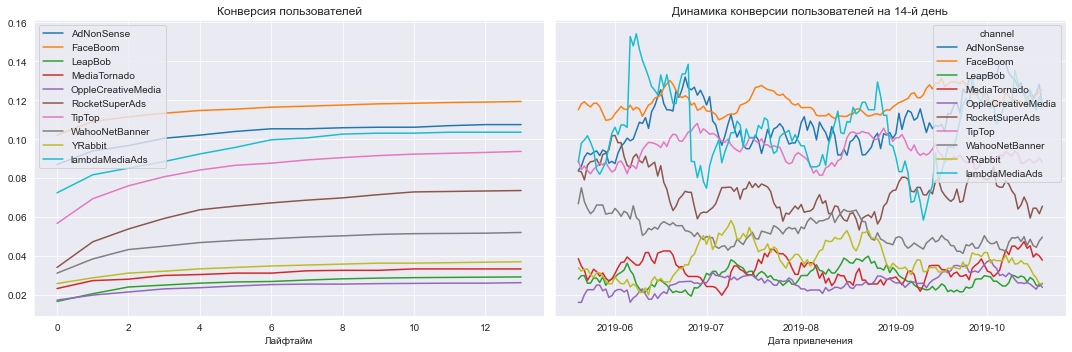

In [38]:
conversion_raw, conversion, conversion_history = get_conversion(profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['channel'])

plot_conversion(conversion, conversion_history, horizon_days, window=20)

У Faceboom, AdNonSense и lambdaMediaAds самые высокие конверсии, более 10%. Несмотря на высокую конверсионность, первые две площадки не окупаются из-за высокого CAC.

Рассмотрим удержание.

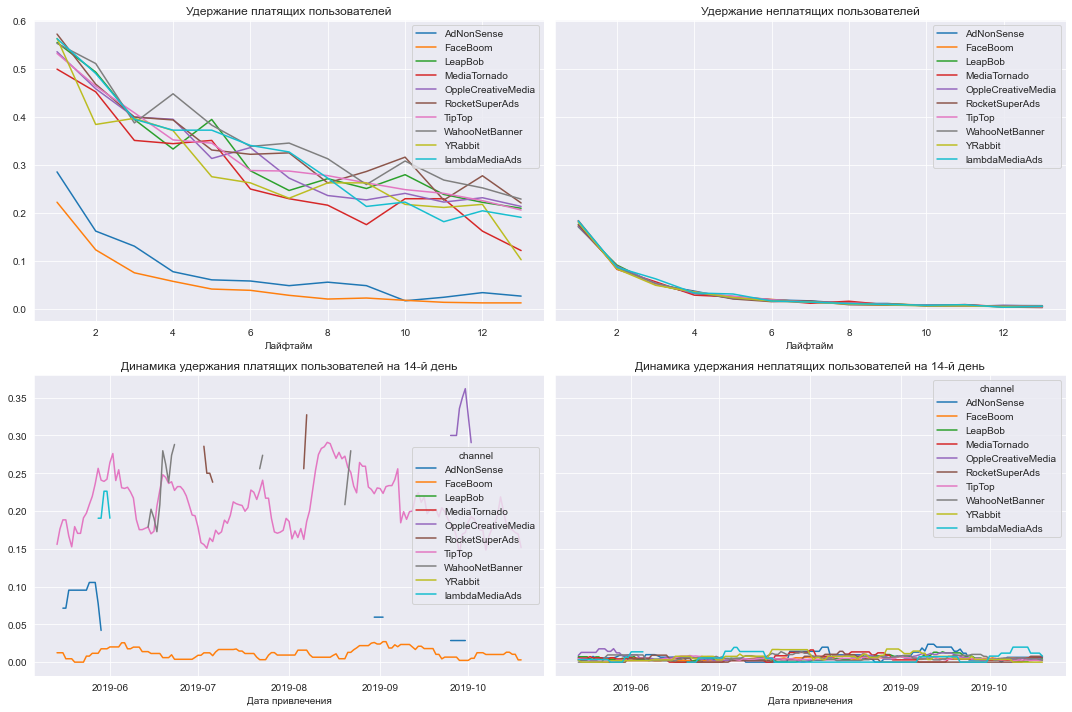

In [39]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['channel'])

plot_retention(retention, retention_history, horizon_days, window=14)

У Faceboom и AdNonSence удержание значительно ниже остальных каналов, менее 5%. Остальные каналы показывают удержание на 14-й день в диапазоне от 10% до 25%. 

### Выводы

**Исследовательский анализ**

* Большинство пользователей приложения из США. Доля платящих пользователей в США также самая высокая, почти 10%.
* Больше всего пользователей заходят в приложение с iPhone. Самая высокая доля платящих пользователей у Mac — 8,95%.
* Больше всего средств было потрачено на источники TipTop и Faceboom: более 5 тыс. и 3 тыс. долларов соответственно. На остальные источники затраты не превысыли и тысячи долларов.
* Расходы на TipTop существенно росли: в июне было потречено около 3,5 тыс. долларов, к сентябрю ежемесячные затраты по этому источнику выросли до 12,5 тыс долларов.
* У площадок TipTop и Faceboom самая высокая средняя стоимость привлечения пользователя: 2,9 и 1,1 долларов соответственно.

**Оценка окупаемости**

* Расходы на рекламу приложения не окупаются — к концу 14-дня ROI составляет менее 100%. Низкая окупаемость связана с существенным увеличением средней стоимости привлечения пользователя. Рост СAC составил от 0,7 долларов в мае до почти 1,3 долларов в октябре.
* Общий LTV все это время оставался относительно стабильным и колебался в пределах от 0,8 до 1 доллара.
* США является единственной страной, где затраты на рекламу не окупаются — ROI на 14-й день составляет около 80%. Для сравнения, ROI других стран варьюируется от 180% до 210%. Это связано со значительным увеличением CAC — за период с мая по октябрь он вырос почти в три раза: с 0,4 долларов до 1,2 долларов. Привлечение американских пользователей не окупается даже с учетом самого высокого LTV.
* Низкая окупаемость в США существенно повлияла на общую окупаемость, так как подавляющее большинство пользователей приложения именно из этой страны.
* Среди всех пользователей приложения окупаются только пользователи PC. Самая низкая окупаемость у пользователей iPhone и Мac, около 70%. При этом ROI стабильно снижается для всех устройств, но для iPhone и Mac падения более выражено. В случае с устройствами низкий ROI также связан с ростом стоимости привлечения.
* Среди каналов привлечения худшие результаты с точки зрения окупаемости показывают AdNonSence, Faceboom и TipTop. Они не окупаются из-за высокой стоимости привлечения пользователя. Лучшие результаты показывают каналы YRabbit, Media Tornado и lambdaMediaAds.
* Падение окупаемости напрямую связано с увеличением расходов на рекламу в дорогих каналах: в июне-июле окупаемость упала ниже 100%, как раз в этот момент расходы на рекламу увеличились в 2 раза — с 4 тыс. долларов до 8 тыс. долларов.
* Около 12% платящих пользователей остаются в приложении на 14-день после привлечения. У неплатящих пользователей этот показатель составлят в районе 1-2%. Динамика удержания в целом стабильная, показатель варьируется от 10% до 15%.
* Удержание пользователей из Франции, Германии и Великобритании на 14-й день находится примерно на одном уровне: от 18% до 20%. У пользователей из США Retention Rate заметно ниже, он составляет всего 10%. 


**Рекомендации**

* Сократить маркетинговые расходы в источниках с низкой окупаемостью, таких как TipTop, Faceboom и AdNonSense и перенести бюджет на каналы с наилучшими показателями, например, YRabbit, Media Tornado и lambdaMediaAds.
* Выяснить точные причины низкого Retention Rate у пользователей из США — низкие показатели могут быть связаны, например, с плохой адаптацией приложения для американского пользователя или техническими ошибками. Повышение удержания потенциально может улучшить LTV пользователей, что в свою очередь может повысить ROI приложения.